# Bag of Words & TF-IDF Text Classification




## Analysis Pipeline
1. NLP text pre-processing
2. Split of training, validation and testing sets
3. Build a simple feed-forward neural net classifier using PyTorch 
4. Train and evaluate BoW and TF-IDF text classifiers 

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import os
import random
import numpy as np
import pandas as pd
import time
import datetime
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pickle
import joblib
from sklearn.utils import shuffle
from subprocess import call
from collections import Counter 
from functools import partial
from nltk.tokenize import wordpunct_tokenize
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm, tqdm_notebook 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
print("Torch version: {}".format(torch.__version__))
print('pyTorch VERSION:', torch.__version__)
print('\n')

print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(['nvidia-smi', '--format=csv', '--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free'])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
torch.cuda.empty_cache()
#PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sun May 22 15:15:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|            

In [5]:
# Set seed
seed_value = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [6]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [7]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [8]:
# Remove comma from tokenize to make one string
df = df.copy()
df['cleanReview'] = df['cleanReview'].apply(lambda x: ','.join(map(str, x)))
df.loc[:,'cleanReview'] =  df['cleanReview'].str.replace(r',', ' ', regex=True)
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,wonderful place get lunch staff friendly effic...
3,5.0,dedicated loving memory gary feldman greatest ...
5,5.0,love place everything menu delicious like tuna...
7,5.0,truely hidden gem place greatest buffalo chick...
9,5.0,seriously great fresh fantastic food spot pric...


In [9]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [10]:
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=20000)

In [11]:
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=20000)
df = pd.concat([df1, df2])
df = shuffle(df)
df = df[['cleanReview', 'stars_reviews']]

del df1, df2

print('Number of records:', len(df), '\n')
print('Number of 5 reviews:', len(df[df.stars_reviews == 1]))
print('Number of 1 & 2 reviews:', len(df[df.stars_reviews == 0]), '\n')

Number of records: 40000 

Number of 5 reviews: 20000
Number of 1 & 2 reviews: 20000 



In [12]:
# Convert data types
df = df.copy()
df[['cleanReview']] = df[['cleanReview']].astype('str')
df['stars_reviews'] = df['stars_reviews'].astype('int')

## Preprocess Text
The reviews were previously prcocessed by removing non-words, lowercase, lemmatized and stop words removed. The reviews need to be re-tokenized.


**Bag of Words** 



**TF-IDF**



**Let's package the pre-processing steps together into functions and apply on our dataset**

In [13]:
def tokenize(text):
    tokens = wordpunct_tokenize(text) # tokenize
    return tokens

def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [14]:
torch.cuda.empty_cache()

In [15]:
# Set parameters
MAX_LEN = 300 
MAX_VOCAB = 10000 

In [16]:
class YelpReviewsDataset(Dataset):
    def __init__(self, df, max_vocab=10000, max_len=300):
        df = df
        
        # Tokenize
        df['tokens'] = df.cleanReview.apply(
            partial(
                tokenize
            ),
        )  
        
        all_tokens = [token for doc in list(df.tokens) for token in doc]
        
        # Build most common tokens bound by max vocab size
        common_tokens = set( 
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0] 
        )
        
        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )
        
        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]  

        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )
        
        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )
        
        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]
        
        self.text = df.cleanReview.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.stars_reviews.tolist()
    
    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.tfidf_vector[i],
            self.targets[i],
            self.text[i],
        )
    
    def __len__(self):
        return len(self.targets)

In [17]:
dataset = YelpReviewsDataset(df, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

100%|██████████| 40000/40000 [00:05<00:00, 6898.17it/s]


In [18]:
del df

See a random sample out of the dataset processed

In [20]:
print('Number of records:', len(dataset), '\n')
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('Sentiment:', sample_target, '\n')

Number of records: 40000 

index: 7296 

trivia night dragged great beer list fair price kept around bethany attentive tended diva need great attitude atmosphere top notch 

[9203, 5899, 2715, 3901, 734, 5116, 3205, 6784, 4820, 429, 0, 518, 8872, 0, 5844, 3901, 522, 501, 9083, 5957] 

BoW vector size: 10001 

TF-IDF vector size: 10001 

Sentiment: 1 



## Split into training, validation, and test sets



In [21]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [22]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.1, test_ratio=0.1)
len(train_dataset), len(valid_dataset), len(test_dataset)

(32000, 4000, 4000)

In [23]:
BATCH_SIZE = 1

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [24]:
print('Number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')
    

Number of training batches: 32000 

Training input sequence: [2530, 813, 3227, 5790, 1159, 5206, 1159, 8969, 435, 536, 3542, 1007, 1159, 1244, 4950, 9514, 257, 3072, 9010, 5914, 337, 8969, 7741, 6079, 2029, 6119, 2688, 2688, 302, 3609, 2688, 2688, 6178, 1159, 0, 2743, 3633, 5133, 3817, 3770, 313, 1443, 7114, 5424, 1957, 598, 2258, 4877, 4267, 1353] 

BoW vector size: 10001 

TF-IDF vector size: 10001 

Label:  tensor(0) 

Review text: disappointed big fan n burger love burger thrilled arrived austin found branch burger california las vegas amazing every time nj anyway thrilled see one course ordered double double animal fries double double overcooked burger andsome dried fry livid going give another chance redeem maybe cook bad day know hope case 



## BoW Model

### Build BoW Model

- Input: BoW Vector
- Model: 
    - feed-forward fully connected network
    - 2 hidden layers
- Output: 
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

In [25]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_labels)
    
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


In [26]:
# Define hidden layer size
HIDDEN1 = 100
HIDDEN2 = 50 

In [27]:
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=10001, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [28]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([100, 10001])
torch.Size([100])
torch.Size([50, 100])
torch.Size([50])
torch.Size([2, 50])
torch.Size([2])


### Train BoW Model



**Define the initial learning rate**



In [29]:
LEARNING_RATE = 6e-5

**Define loss function and gradient descent optimizer**


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training & validation rounds**

In [31]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [32]:
%cd /content/drive/MyDrive/Yelp_Reviews/DL/BoW/ReviewStars/

/content/drive/MyDrive/Yelp_Reviews/DL/BoW/ReviewStars


In [33]:
#  Save the general checkpoint
EPOCH = 1
OUT_DIR = './Models/40k_batch1_lr6e_5_10kRW_baseline.pt'
LOSS = 0.4  

Train the Model

In [34]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 4.15e-01	valid_loss: 3.64e-01

epoch #  2	train_loss: 3.50e-01	valid_loss: 3.59e-01

epoch #  3	train_loss: 3.42e-01	valid_loss: 3.58e-01

epoch #  4	train_loss: 3.38e-01	valid_loss: 3.58e-01

epoch #  5	train_loss: 3.35e-01	valid_loss: 3.58e-01

epoch #  6	train_loss: 3.32e-01	valid_loss: 3.58e-01

epoch #  7	train_loss: 3.31e-01	valid_loss: 3.58e-01

Stopping early


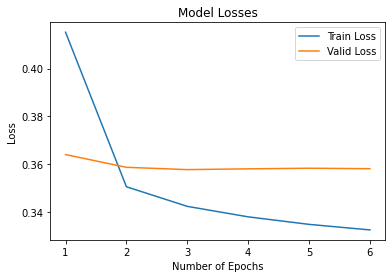

In [35]:
my_dpi=96
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Model Losses') 
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.savefig('BoW_40k_batch1_lr6e_5_10kRW_baseline_Loss.png', dpi=my_dpi * 10,
               bbox_inches='tight')
plt.show()

### Check Performance of BoW Model

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2053
           1       0.95      0.96      0.96      1947

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



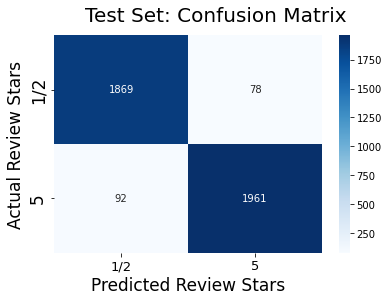

In [36]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)
        if input_type == 'tdidf':
            inputs = tfidf
            probs = tfidf_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)

print('Classification Report:')         
print(classification_report(y_true, y_pred))

f, (ax) = plt.subplots(1, 1) 
f.suptitle('Test Set: Confusion Matrix', fontsize = 20)
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")


ax.set_xlabel('Predicted Review Stars', fontsize=17)
ax.set_ylabel('Actual Review Stars', fontsize=17)
ax.xaxis.set_ticklabels(['1/2', '5'], fontsize=13)
ax.yaxis.set_ticklabels(['1/2', '5'], fontsize=17)
f.savefig('RS_BoW_40K_batch1_lr6e_5_10kRW_testSet_CF.png', 
          dpi=my_dpi, bbox_inches='tight')

**Examine a few examples**

In [37]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, tfidf_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, tfidf_lst, target_lst, text_lst))

def print_random_prediction(model, n=5, input_type='bow'):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, tdidf, target, text = random.choice(test_examples)
            target = target.item()
            
            inputs = bow
            if input_type == 'tdidf':
                inputs = tfidf

            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)
            
            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [38]:
print_random_prediction(bow_model, n=5, input_type='bow')

Number,Review,Predicted,Actual
1,absolutely horrible place vegetable fruit dirty every time went mistake went four time never variety staff rude list go honestly understand people go save much awful grocery shopping experience,😡,😡
2,went hank celebrate special occasion friend food tasty service horrible server kizzy j mia evening never cleared table brought water refill without asking night wore appeared get loaded know slurred speech bumping folk forgetful labored action something expect type restaurant recalled review chronicle sum experience beef hank though come service everyone friendly wellmeaning apart diffident host attention detail overall professionalism every time asked implement necessary dine without set food table otherwise compromise hygiene standard service staff seemed taken aback surprising request especially restaurant look feel higherend establishment enough said good food poor service sad way celebrate friend,😡,😡
3,wish could give better review food bland overpriced service friendly weird slow back,😡,😡
4,year living nearby promising getting sidetracked fish chip pirate pub door away finally made dinner last night surprise chilli house thai bistro added option surprise hostess assumed pigout big guy need decide whether going la carte ayce upfront seated different section opted good value ayce seated front section waitress server fast efficient blink ordered every dish appetizer soupsalad stir fry section food arrived quickly generally tasty although steam table cooked order tackled curry noodle rice section although best section relying waitress choice lot food dish better earlier course worth trying first make dessert glutinous rice tapioca two singha beer tax builtin tip bill grew rounded service star sometimes quality matter quantity pig nothing remotely nice food bangkok la likely thai restaurant vancouver however weather nice front terrace ace sharing bottle wine two mother day weekend early heatwave watching crowd walk cycle rollerblade drinking great weather would like lot low price feel free add another star two,😄,😡
5,location past least time couple night stay working location done nice job renovating lobby common area welcoming feel walk door room nicely appointed rehabbed within last year usually plenty picture attach sadly occasion would able take picture flea bite arm actually caught one flea since easy kill flushed toilet course flea never travel alone second night stay bite wish known pet friendly hotel would asked pet room hoping praying bite carry lyme disease whatever yes kind asking another room conference day hour long changing late evening would feasible given little time sleep give hotel thumb little refrigerator able keep yogurt cold great override flea bite though burger restaurant hotel great different stay walked room find carpet soaking wet mean soaking wet would even assign room guest took little hour get room changed made short night sleep important conference good truly like write le positive review time let needing nearby airport stay know company arranged accommodation never return hotel make reservation elsewhere never,😡,😡


## TF-IDF Model


### Initialize TF-IDF Model 

In [39]:
tfidf_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
tfidf_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=10001, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

### Train TF-IDF Model

TF-IDF vectors as input

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, tfidf_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [41]:
%cd /content/drive/MyDrive/Yelp_Reviews/DL/TFIDF/ReviewStars/

/content/drive/MyDrive/Yelp_Reviews/DL/TFIDF/ReviewStars


In [42]:
#  Save the general checkpoint
EPOCH = 1
OUT_DIR = './Models/40k_batch1_lr6e_5_10kRW_baseline.pt'
LOSS = 0.4   

In [43]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(tfidf_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(tfidf_model, valid_loader, input_type='tfidf')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 4.55e-01	valid_loss: 3.67e-01

epoch #  2	train_loss: 3.52e-01	valid_loss: 3.57e-01

epoch #  3	train_loss: 3.43e-01	valid_loss: 3.55e-01

epoch #  4	train_loss: 3.38e-01	valid_loss: 3.55e-01

epoch #  5	train_loss: 3.35e-01	valid_loss: 3.55e-01

epoch #  6	train_loss: 3.33e-01	valid_loss: 3.56e-01

Stopping early


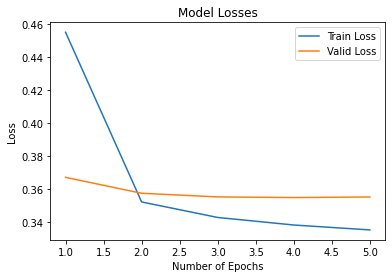

In [44]:
my_dpi=96
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Model Losses') 
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.savefig('RS_TFIDF_40k_batch1_lr6e_5_10kRW_Loss.png', dpi=my_dpi * 10,
               bbox_inches='tight')
plt.show()

### TF-IDF Performance

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2052
           1       0.96      0.96      0.96      1948

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



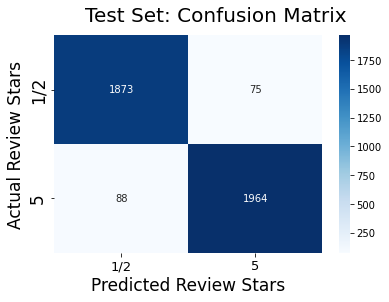

In [45]:
tfidf_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = tfidf_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)

print('Classification Report:')        
print(classification_report(y_true, y_pred))

f, (ax) = plt.subplots(1, 1) 
f.suptitle('Test Set: Confusion Matrix', fontsize = 20)
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")


ax.set_xlabel('Predicted Review Stars', fontsize=17)
ax.set_ylabel('Actual Review Stars', fontsize=17)
ax.xaxis.set_ticklabels(['1/2', '5'], fontsize=13)
ax.yaxis.set_ticklabels(['1/2', '5'], fontsize=17)
f.savefig('RS_TFIDF_40K_batch1_lr6e_5_10kRW_testSet_CF.png', 
          dpi=my_dpi, bbox_inches='tight')

In [46]:
print_random_prediction(tfidf_model, n=5, input_type='tfidf')

Number,Review,Predicted,Actual
1,ordered bang bang shrimp chicken today lunch doordash shocked bad delivered burnt shrimp sauce bland nothing taste star food throw star get review show throw away paid food tip money drain,😡,😡
2,experience august stoked come crust burnt really could enjoy flavor back,😡,😡
3,amazing service amazing atmosphere amazing food diverse menu everything ordered good pizza burger pasta fish nacho amazing,😄,😄
4,love love love noodle one place get every time go good tried different size noodle many trial believe fettuccini best noodle type stirfried noodle pappardelle little thick throw noodle meatveggie ratio cold sesame noodle good day hot warm food sushi happy hour pretty awesome also tempura shrimp pretty standard good really nice sit patio back weather nice get kind loud inside normal busy time,😄,😄
5,place great big menu lot variety never gotten order wrong order online via website service great cheesy garlic breadstick amazing also love club sandwich,😄,😄
